# Exploratory Data Analysis of Superconductive Materials Composition and Critical Temperature (Tc)
This is an exploration of the Superconductivity dataset hosted by the UC - Irvine Machine Learning Repository
https://archive.ics.uci.edu/dataset/464/superconductivty+data

The dataset author lightly cleaned data on chemical composition and critical temperature for over 21,200 known superconductors available from Japan's National Institute of Materials Science and then used that data with well-known elemental properties for each component like atomic weight, electron affinity, and thermal conductivity to derive 10 extracted features - mean, geometric mean, entropy, range, and standard deviation, each calculated once naively and once weighted proportional to composition - per element property across 8 elemental properties, and then also included the number of elements as one additional feature for a total of 81 extracted features. Elemental properties are atomic mass, first ionization energy, atomic radius, density, electron affinity, heat of fusion (the energy difference between solid and liquid at exactly the freezing point under constant pressure), thermal conductivity, and valence. 

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import normalize 

# Plot styles
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['font.size'] = 11
from matplotlib.ticker import FuncFormatter

## Data Exploration

In [175]:
df = pd.read_csv('data/train.csv')

In [176]:
df.head()

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   
3                 1.022291          122.90607              33.768010   
4                 1.129224          122.90607              27.848743   

   std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  wtd_gmean_Valence  \
0        51.968828  ...          2.257143       2.213364           2.219783   
1        47.094633  ...          2.257143       1.888175           2.210679   
2        51.968828  ...          2.271429       2.213364           2.232679   
3        51.968828  ...          2.264286       2.213364           2.226222   
4        51.968828  ...          2.242857       2.213364           2.206963   

   entropy_Valence  wtd_entropy_Valence  range_Valence  wtd_range_Valence  \
0         1.368922             1.066221              1           1.085714   
1         1.557113             1.047221              2           1.128571   
2         1.368922             1.029175              1           1.114286   
3         1.368922             1.048834              1           1.100000   
4         1.368922             1.096052              1           1.057143   

   std_Valence  wtd_std_Valence  critical_temp  
0     0.433013         0.437059           29.0  
1     0.632456         0.468606           26.0  
2     0.433013         0.444697           19.0  
3     0.433013         0.440952           22.0  
4     0.433013         0.428809           23.0  

[5 rows x 82 columns]

It is convenient that all features are numerical. However for exploratory analysis, it may be useful to include some information about the chemical composition to visualize categories of superconductor based on composition.

In [177]:
chemcomp = pd.read_csv('data/unique_m.csv')

In [178]:
chemcomp.shape # 87 elements 

(21263, 88)

In [179]:
chemcomp = chemcomp.drop(columns=['He','Ne','Ar','Kr','Xe','Pm','Po','At','Rn']) # dropping unused elements, mainly noble gasses

In [180]:
 # Normalizing chem proportions for direct comparisons
norm_chemcomp = chemcomp.drop(columns=['critical_temp','material'])
norm_chemcomp = norm_chemcomp.div(norm_chemcomp.sum(axis=1),axis=0)

Text(0.5, 1.0, 'Primary Non-Oxygen Element in Material Composition')

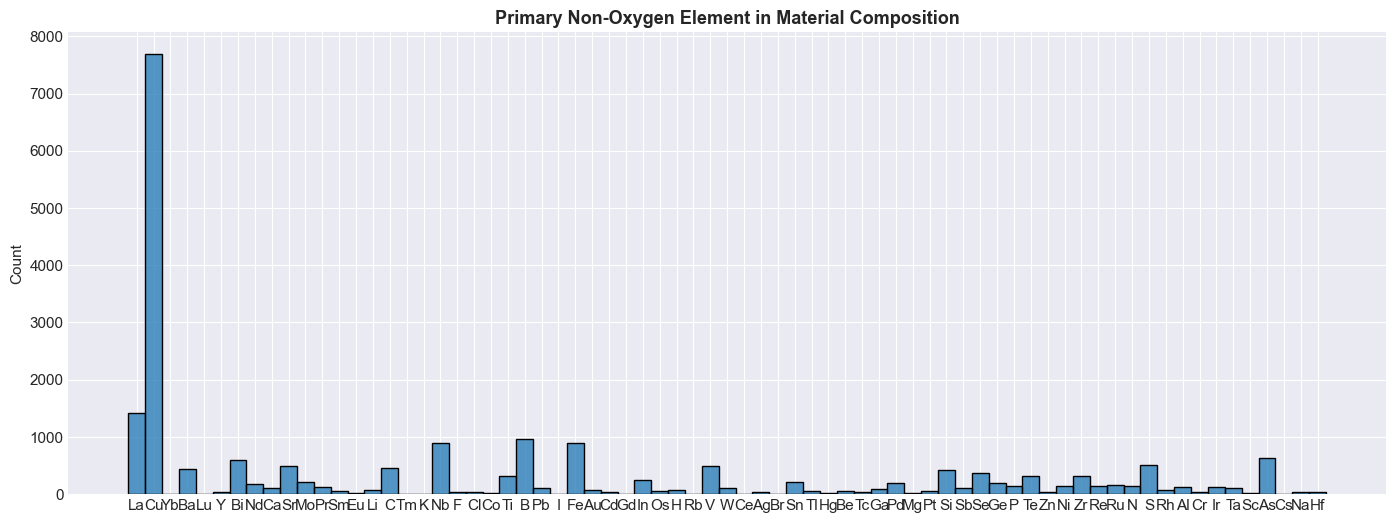

In [181]:
basis= norm_chemcomp.drop(columns=['O']).idxmax(axis=1)

plt.figure(figsize=(17,6))
sns.histplot(basis)
plt.title('Primary Non-Oxygen Element in Material Composition')

Unsurprisingly, a large proportion of the materials are cuprous (copper-based). 

Text(0.5, 1.0, 'Log-Tranformed Mean Proportion Across All Compositions')

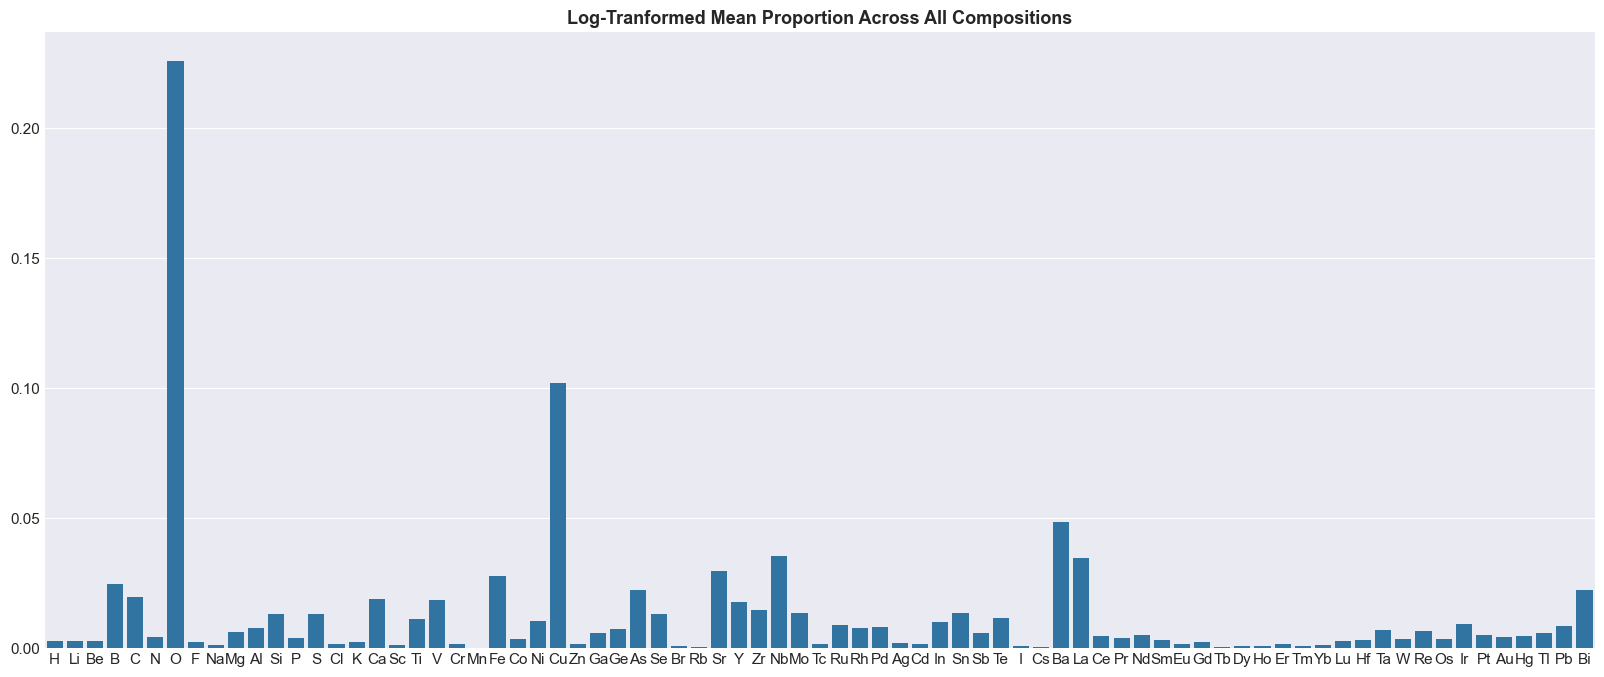

In [182]:
# A quick look at overall prevalence of elements in our chemical compositions, adjusted logarithmically.
# Shows that a huge amount of the data is cuprous oxides. 
plt.figure(figsize=(20,8))
sns.barplot(np.log1p(norm_chemcomp.mean()))
plt.title('Log-Tranformed Mean Proportion Across All Compositions')

Text(0.5, 1.0, 'Correlation in Elemental Composition')

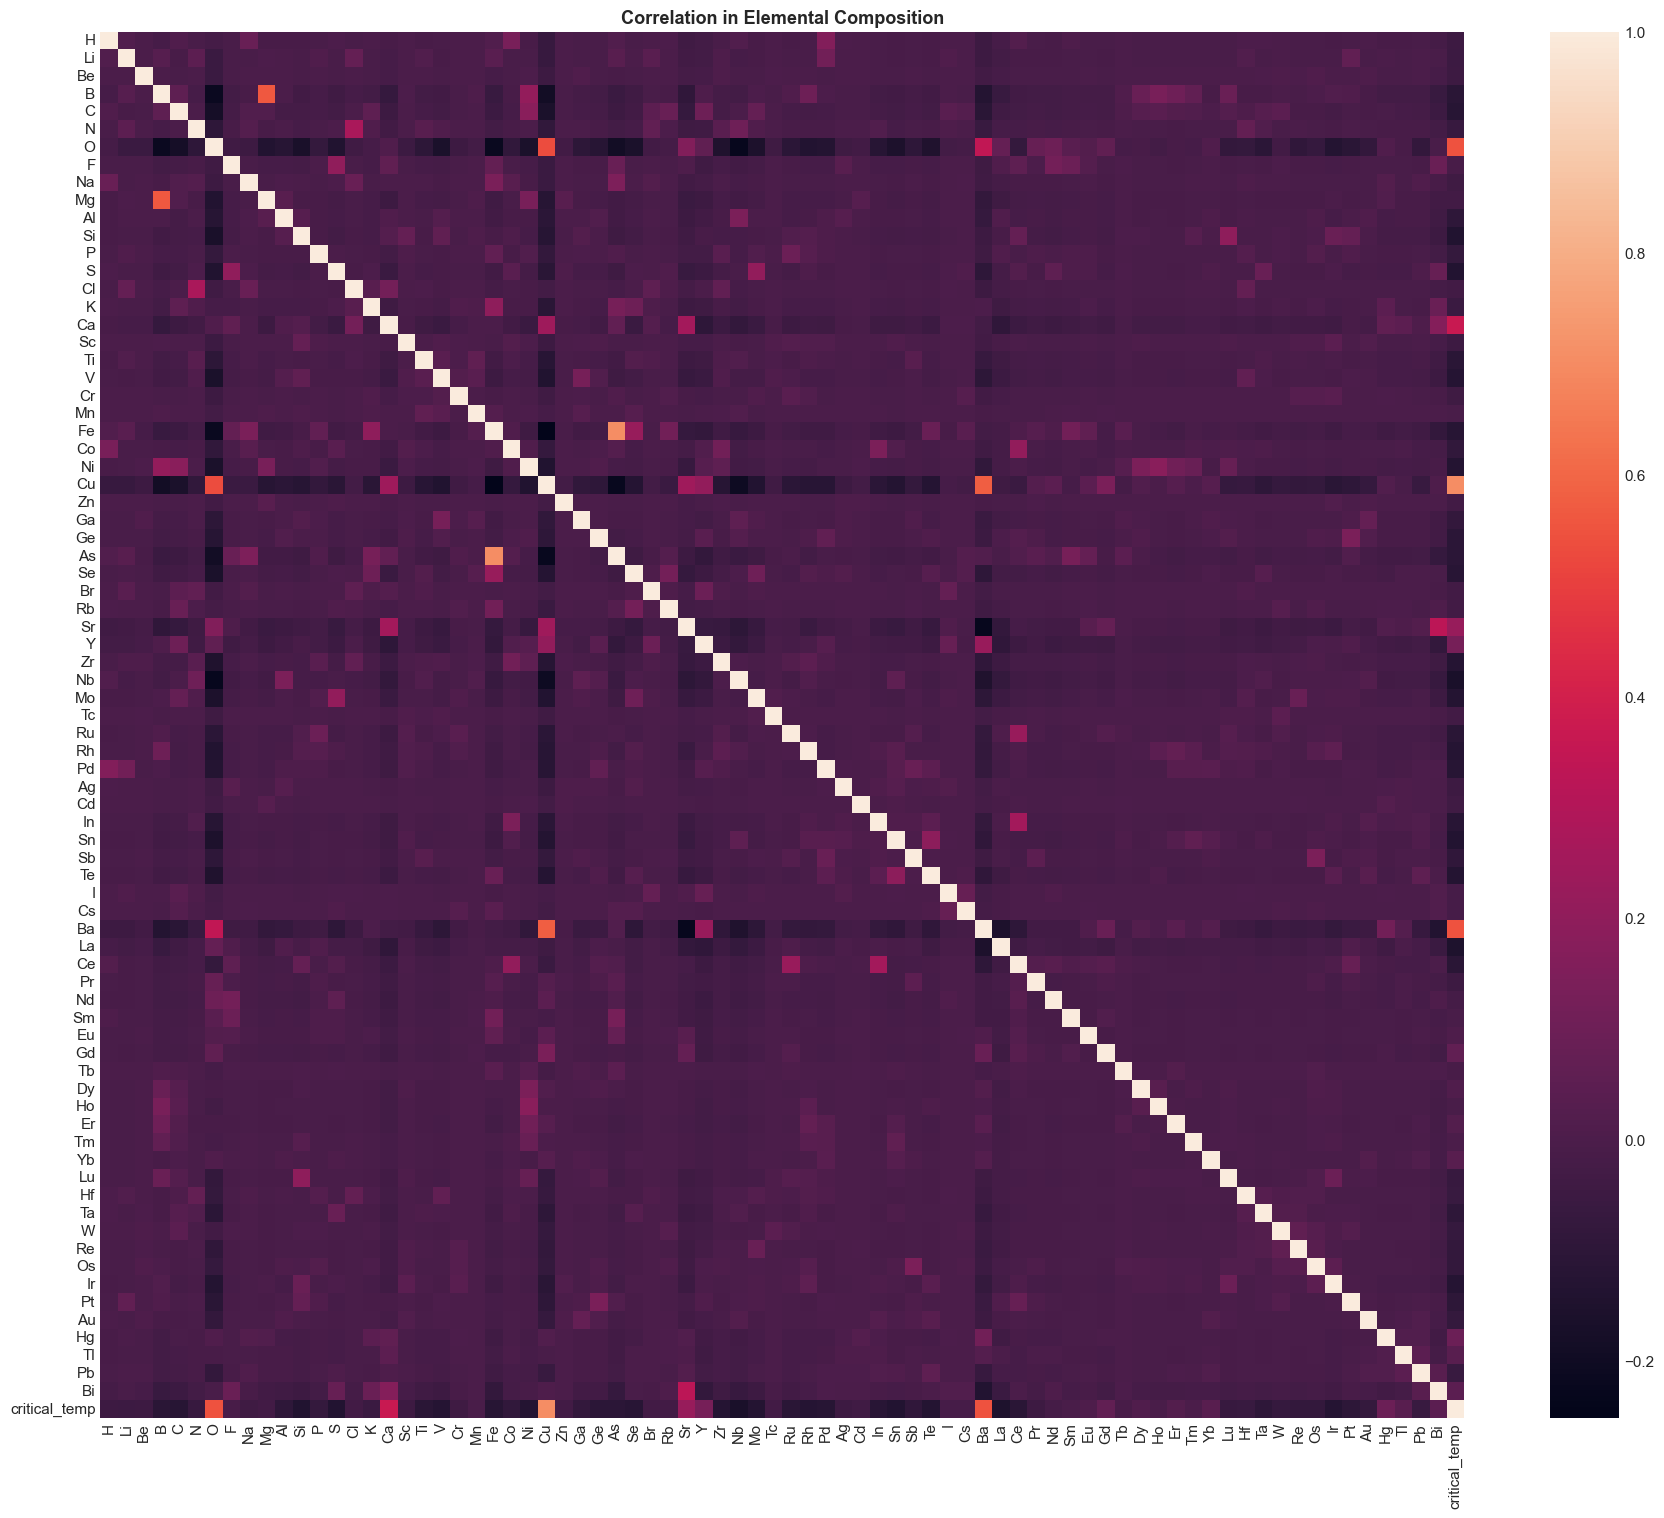

In [183]:
norm_chemcomp['critical_temp']= chemcomp['critical_temp'] #adding back target
chem_corr = norm_chemcomp.corr() 
plt.figure(figsize=(22,18))
sns.heatmap(chem_corr, cbar=True)
plt.title('Correlation in Elemental Composition')

So we see some interesting correlations for materials in our dataset. Seeing the prevalence of high-temp *CBOx superconductors on target correlation. Now let's take a look at the distribution of our target value, the critical temp.

Text(0.5, 1.0, 'Distribution of Critical Temperatures')

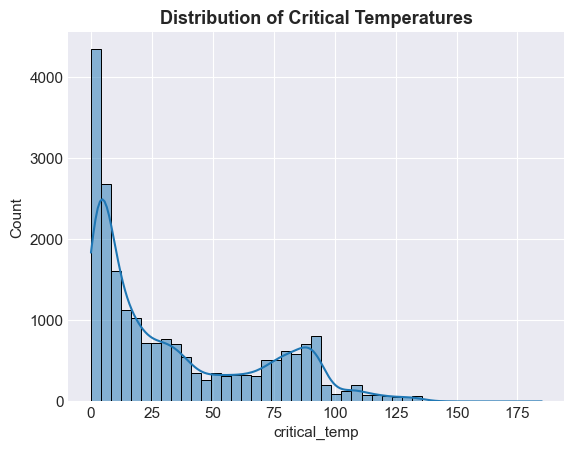

In [184]:
sns.histplot(data=df,x='critical_temp',kde=True)
plt.title('Distribution of Critical Temperatures')

We see a slight bump over 75 Kelvin representing interest in - and intensive investigation of - high-temperature superconductors. This is generally accepted to mean superconductors whose critical temperature is higher than the boiling temperature of nitrogen, which is 77 Kelvin. The outlier at 175 Kelvin demands serious scrutiny.

In [185]:
chemcomp['material'][chemcomp['critical_temp'].idxmax()] # Hydrogen Sulfide, now it makes sense.

'H2S1'

So, this data point is arguably a real superconductor, but it is NOT like the others - hydrogen sulfide is normally a gas and only superconducts at extreme high pressures. The other data was collected under normal atmosphere, with at most a handful of much-less-remarkable exceptions, so including H2S without including pressure data is only going to add confusion. Maybe it won't hurt the model that much, but I also don't want it to make visualizations more difficult, so I'm going to kick it out. 

In [186]:
chemcomp = chemcomp.drop(index=chemcomp['critical_temp'].idxmax())
norm_chemcomp = norm_chemcomp.drop(index=chemcomp['critical_temp'].idxmax())
df = df.drop(index=df['critical_temp'].idxmax())

Text(0.5, 1.0, 'Distribution of Number of Elements in Material Composition')

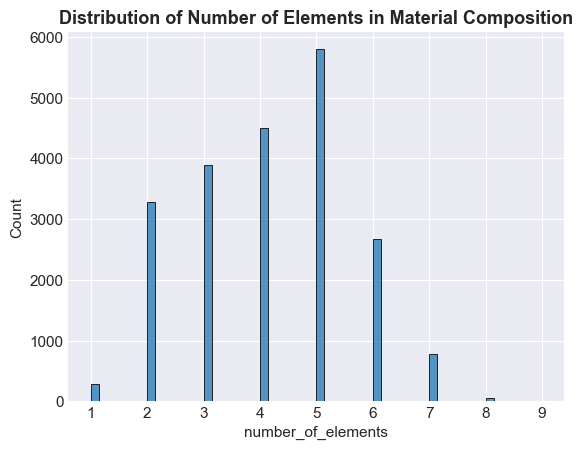

In [187]:
sns.histplot(data=df,x='number_of_elements')
plt.title('Distribution of Number of Elements in Material Composition')

Text(0.5, 1.0, 'Critical Temp vs Number of Elements')

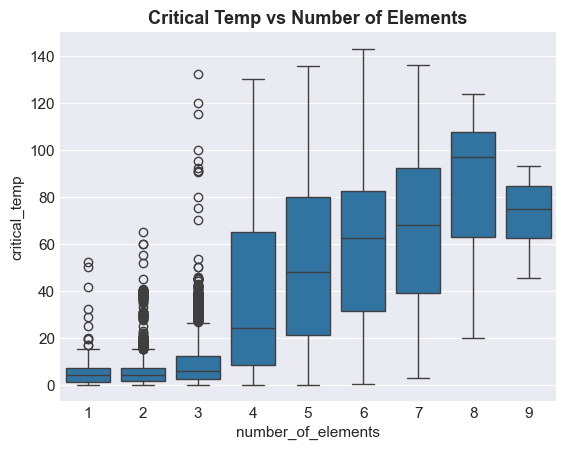

In [188]:
sns.boxplot(data=df, x='number_of_elements',y='critical_temp')
plt.title("Critical Temp vs Number of Elements")

In [189]:
calculated_features = list(df.drop(columns=['number_of_elements','critical_temp']).columns)

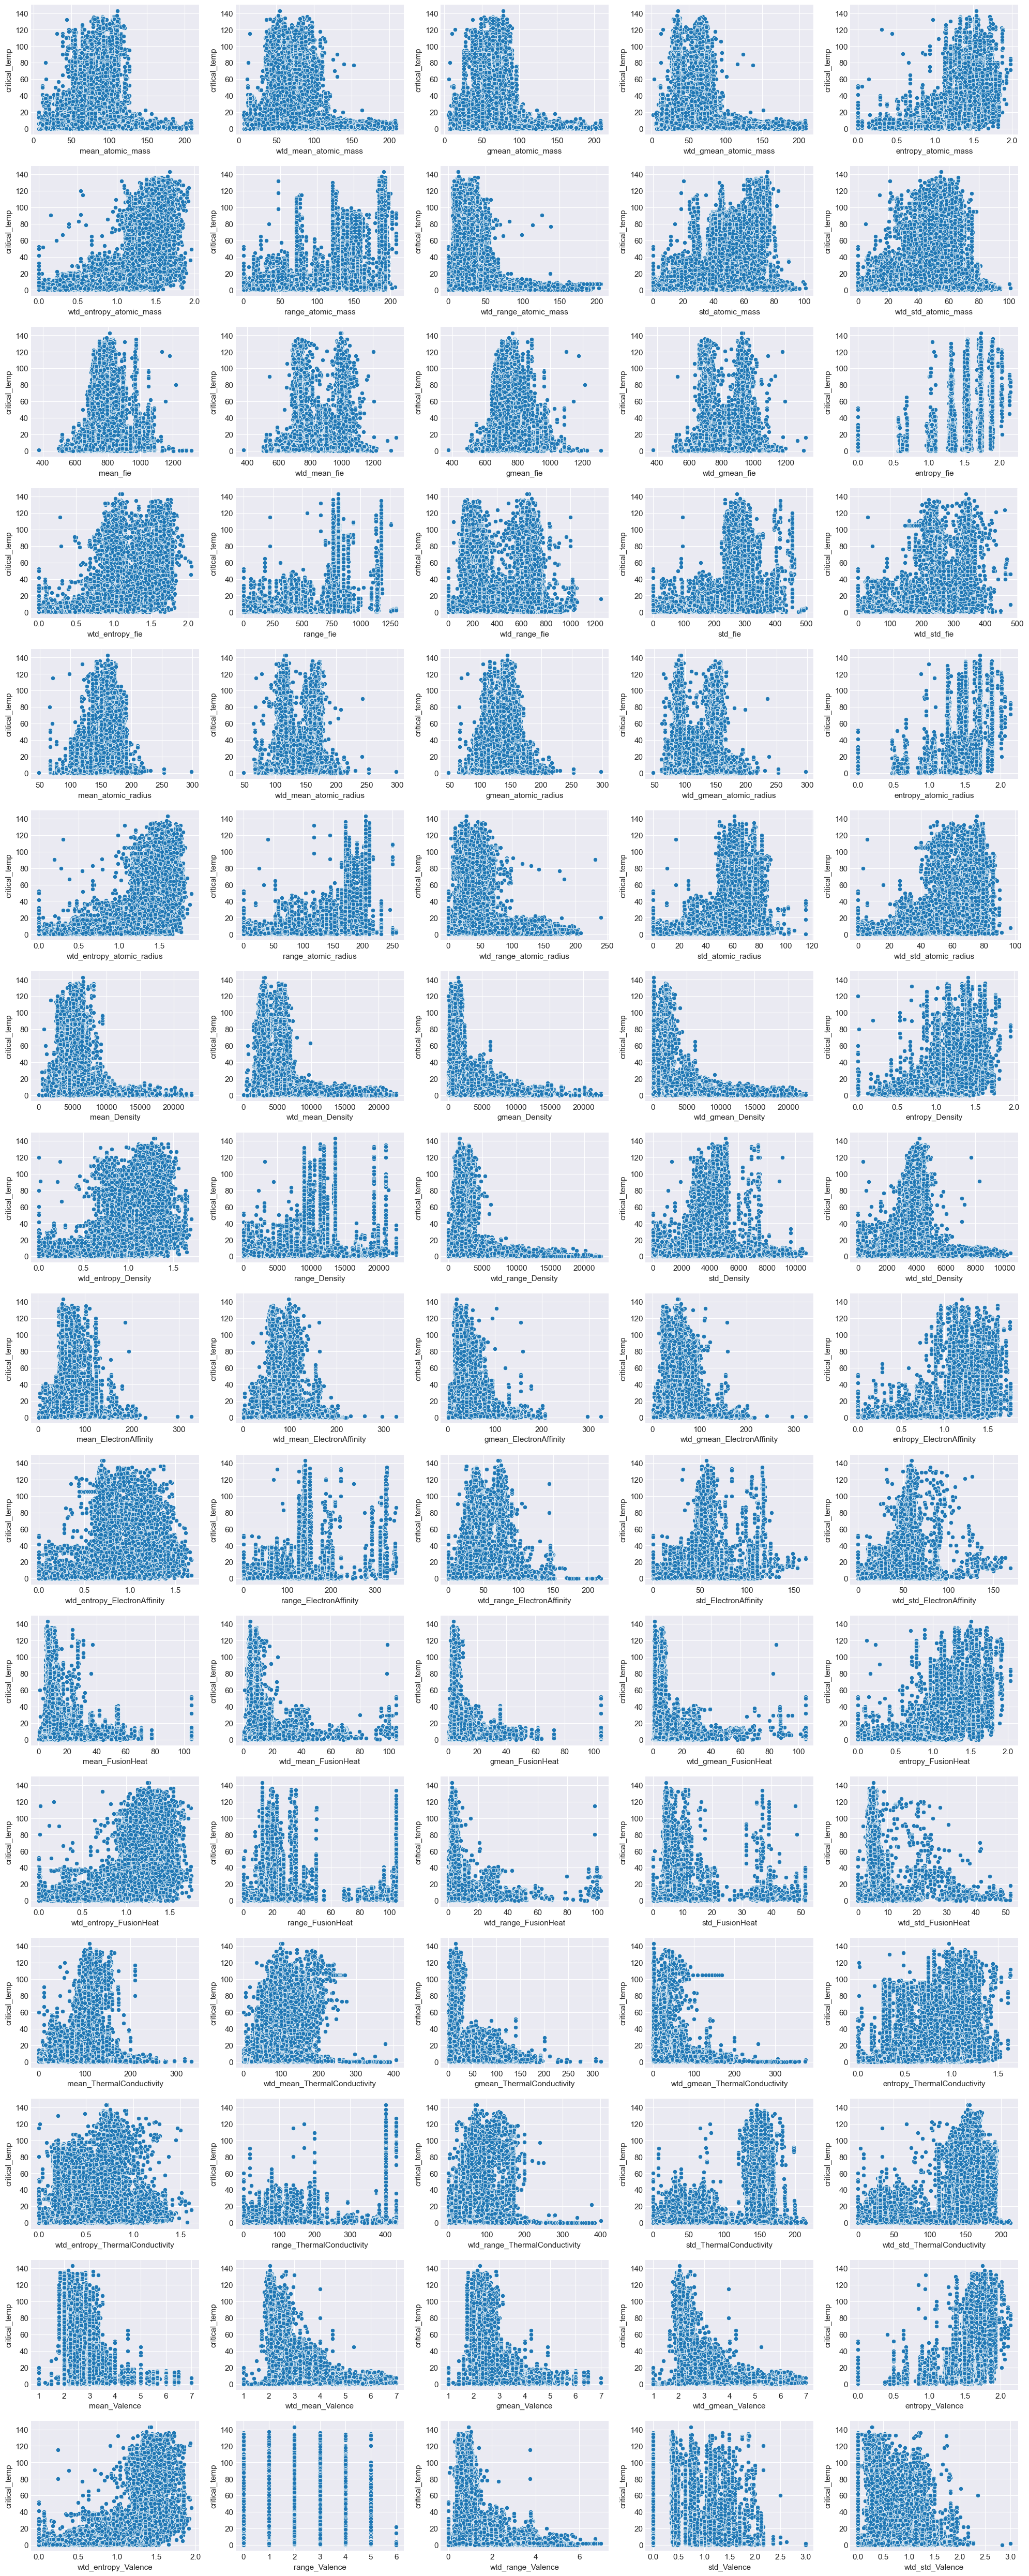

In [190]:
fig, axes = plt.subplots(16, 5, figsize=(20, 50))
for n, col in enumerate(calculated_features):
    ax = axes[n//5][n%5]
    sns.scatterplot(data=df, x=col, y='critical_temp', ax=ax)
plt.tight_layout();

Quite a lot to see here! Although all of our features show high variance, there is clustering around certain values for high critical temperatures, with maximum Tc values following something like a normally distributed curve. Exciting! 

Obviously, since our features are derived from the same 8 interrelated elemental properties, they are going to have high correlation, but let's take a look at our feature correlations anyway. 

Text(0.5, 1.0, 'Correlation in Derived Features')

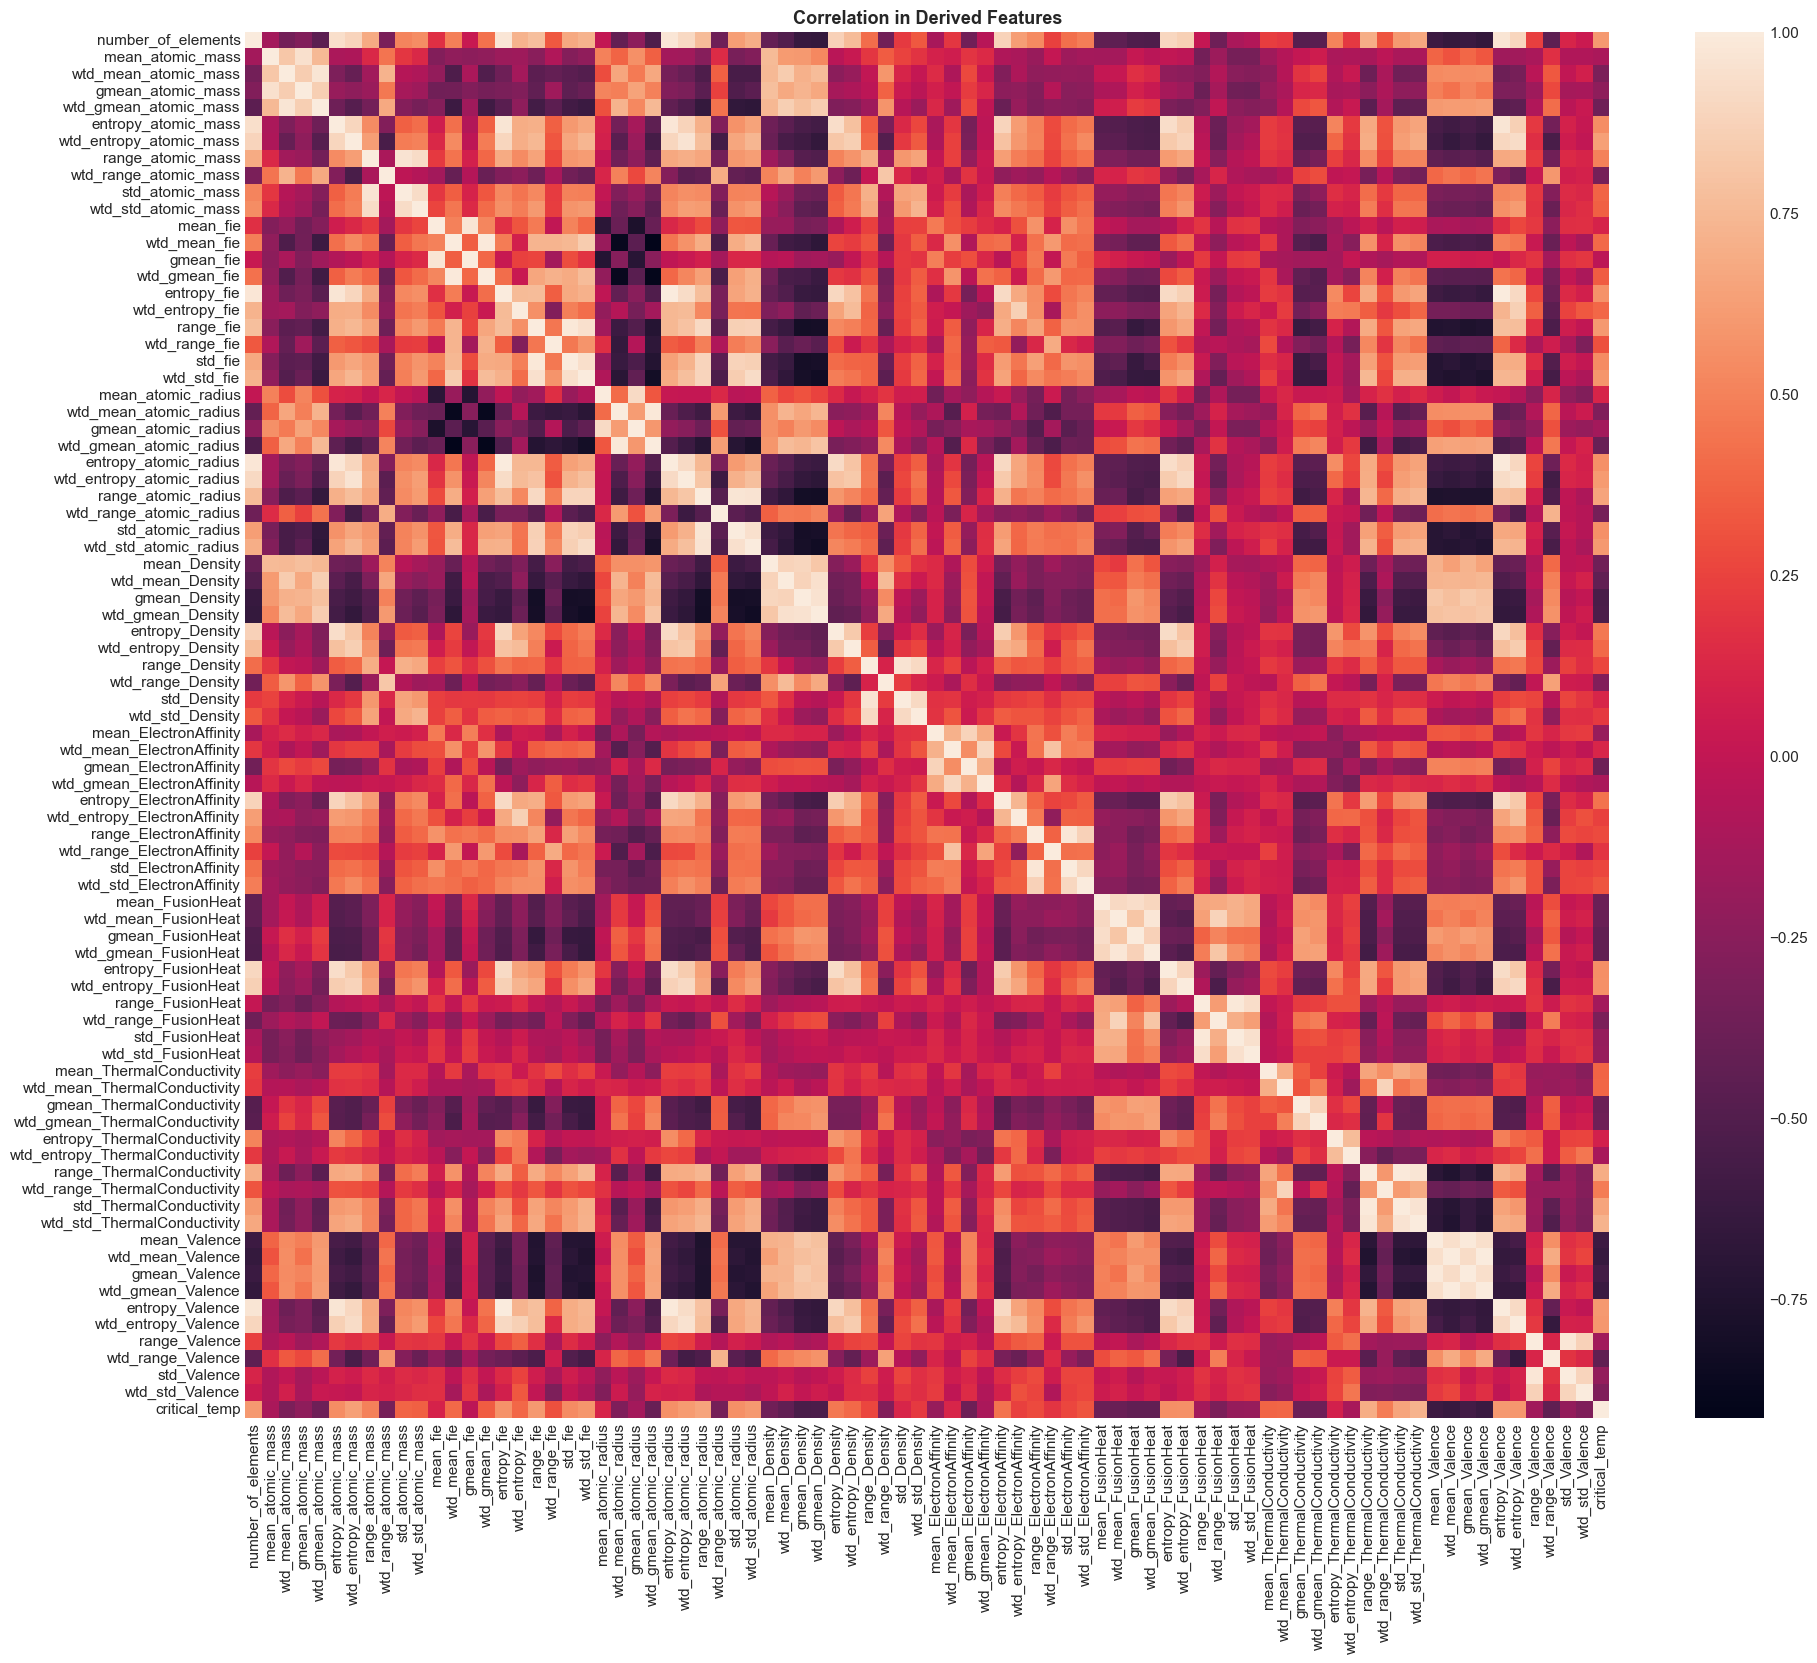

In [191]:
feature_corr = df.corr()
plt.figure(figsize=(22,18))
sns.heatmap(feature_corr, cbar=True)
plt.title('Correlation in Derived Features')

As expected, seeing a lot of large positive and negative correlations across this dataset, however there are also some extremely strong correlations with our target - a very promising outlook. This does seem like a dataset that could withstand some dimensionality reduction later, though.

Let's visualize the target correlations more clearly!

C:\Users\erica\AppData\Local\Temp\ipykernel_10620\1525527449.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tc_corr['correlation_with_Tc'], y=tc_corr['feature'], orient='h', palette='plasma')


<Axes: xlabel='correlation_with_Tc', ylabel='feature'>

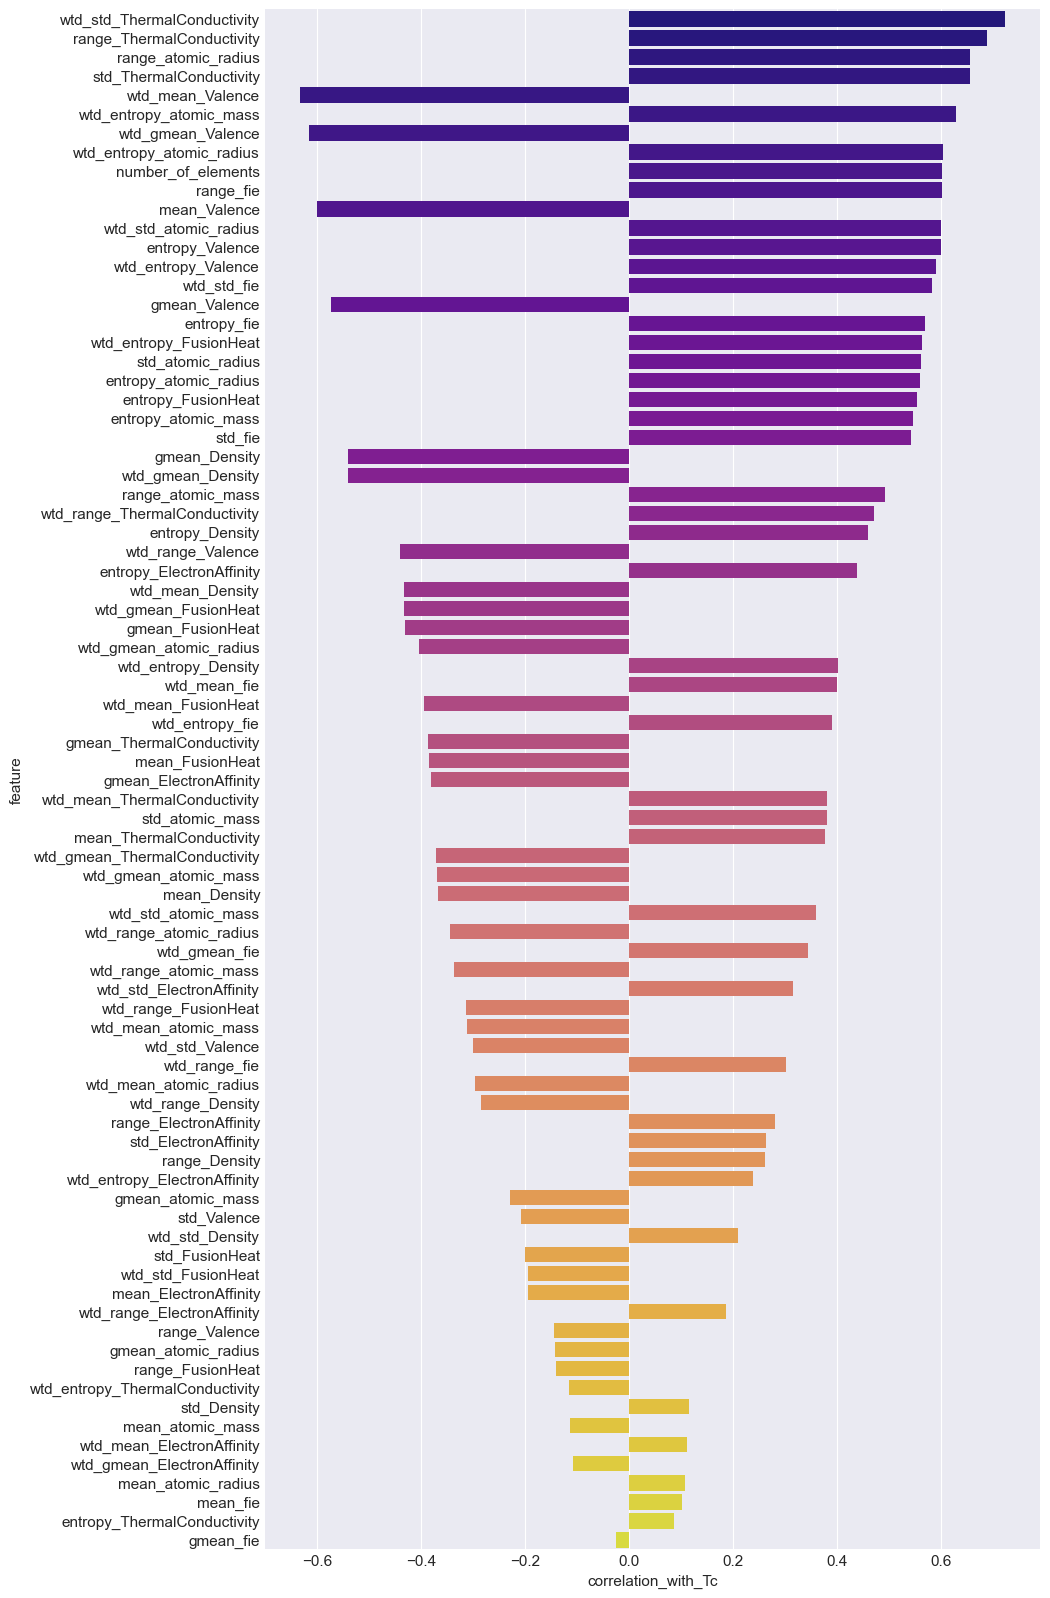

In [192]:

tc_corr = feature_corr['critical_temp'].drop(index='critical_temp').reset_index()
tc_corr.columns = ['feature','correlation_with_Tc']
tc_corr['absolute_correlation'] = tc_corr['correlation_with_Tc'].abs()
tc_corr = tc_corr.sort_values('absolute_correlation',ascending=False)

plt.figure(figsize=(10,20))
sns.barplot(x=tc_corr['correlation_with_Tc'], y=tc_corr['feature'], orient='h', palette='plasma')

Now we're seeing just how much our model is going to have to work with here. Now I am wondering - do unweighted features align very closely with their weighted counterparts? How much do our top features derived from different properties correlate? How does Tc correlate with oxidation level? With proportion of copper? Let's give chemical composition the same treatment first.

C:\Users\erica\AppData\Local\Temp\ipykernel_10620\1626000807.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tc_chem_corr['correlation_with_Tc'], y=tc_chem_corr['element'], orient='h', palette='plasma')


<Axes: xlabel='correlation_with_Tc', ylabel='element'>

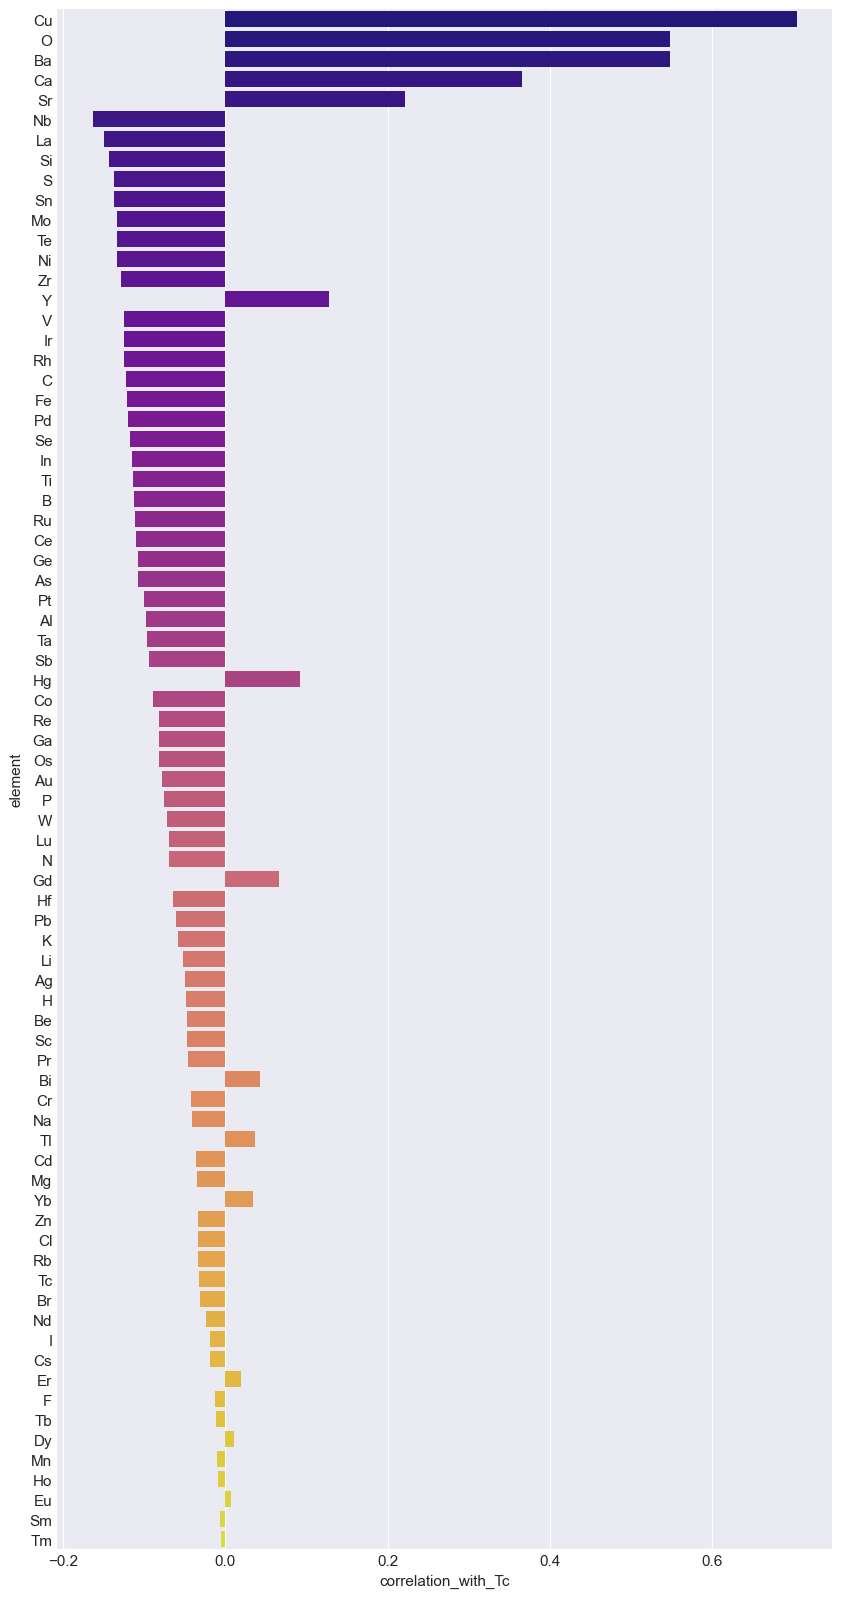

In [193]:
tc_chem_corr = chem_corr['critical_temp'].drop(index='critical_temp').reset_index()
tc_chem_corr.columns = ['element','correlation_with_Tc']
tc_chem_corr['absolute_correlation'] = tc_chem_corr['correlation_with_Tc'].abs()
tc_chem_corr = tc_chem_corr.sort_values('absolute_correlation',ascending=False)

plt.figure(figsize=(10,20))
sns.barplot(x=tc_chem_corr['correlation_with_Tc'], y=tc_chem_corr['element'], orient='h', palette='plasma')

Unsurprising that cuprous oxides containing barium correlate most positively to high Tc. I think we may need to demonstrate that a model based on our derived features performs better than a model based on chemical proportions alone and ensure that it's fitting to materials properties and not simply overfitted to the high number of *CBOx varieties.

Text(0.5, 1.0, 'Oxidation Level and Tc, Colored for Copper Proportion')

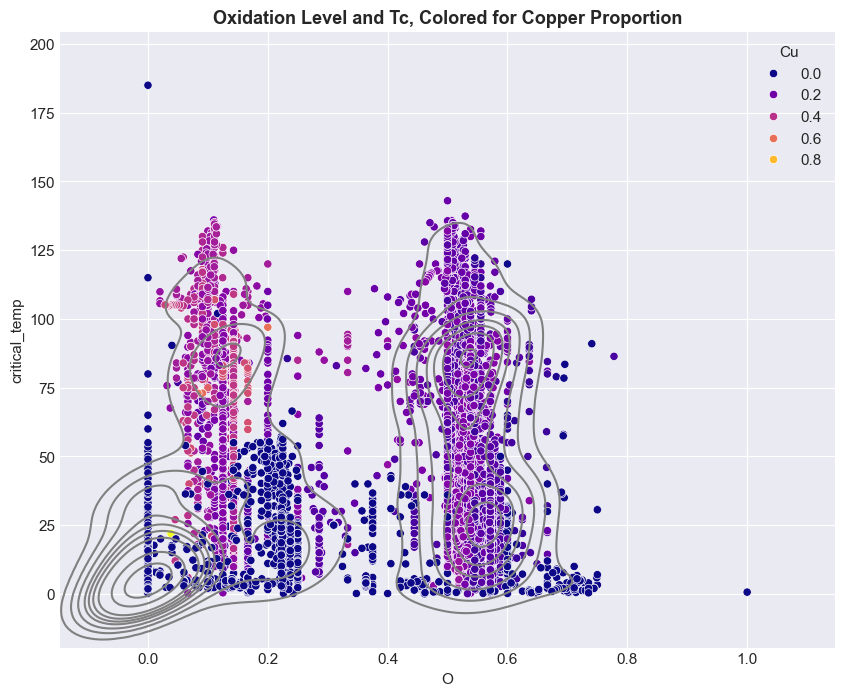

In [ ]:
# How does oxidation level correspond to Tc?
fig, ax = plt.subplots(figsize = (10, 8))
sns.scatterplot(data=norm_chemcomp, x= 'O', y= 'critical_temp', ax=ax, palette='plasma',hue='Cu')
plt.title('Oxidation Level and Tc, Colored for Copper Proportion')

Text(0.5, 1.0, 'Copper Proportion vs Critical Temperature, Colored by Oxidation Level')

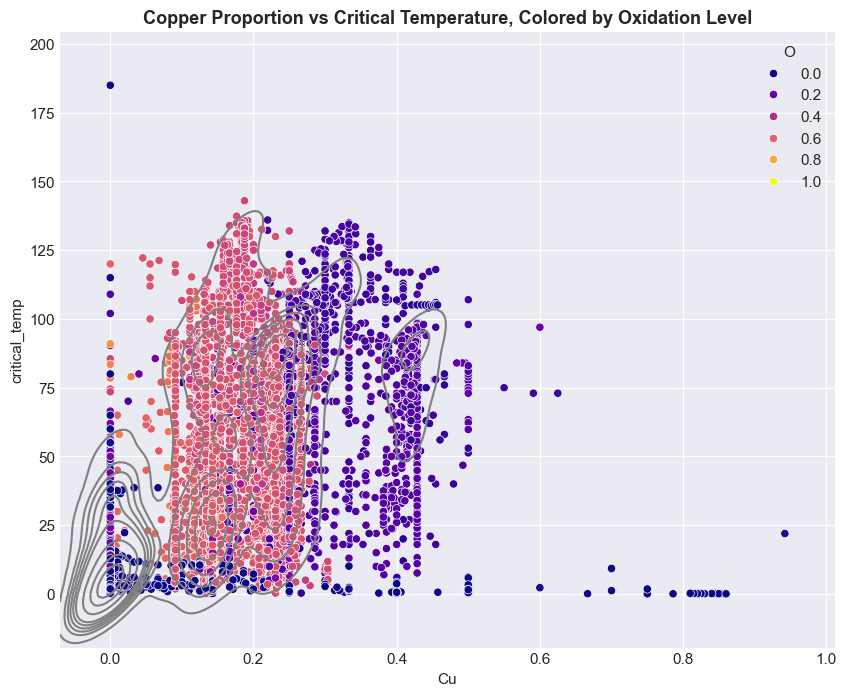

In [ ]:
# How does copper proportion relate to Tc? 
fig, ax = plt.subplots(figsize = (10, 8))
sns.scatterplot(data=norm_chemcomp, x= 'Cu', y= 'critical_temp', ax=ax, palette='plasma', hue='O')
plt.title('Copper Proportion vs Critical Temperature, Colored by Oxidation Level')

Text(0.5, 1.0, 'Copper Proportion vs Oxidation, Colored by Critical Temperature')

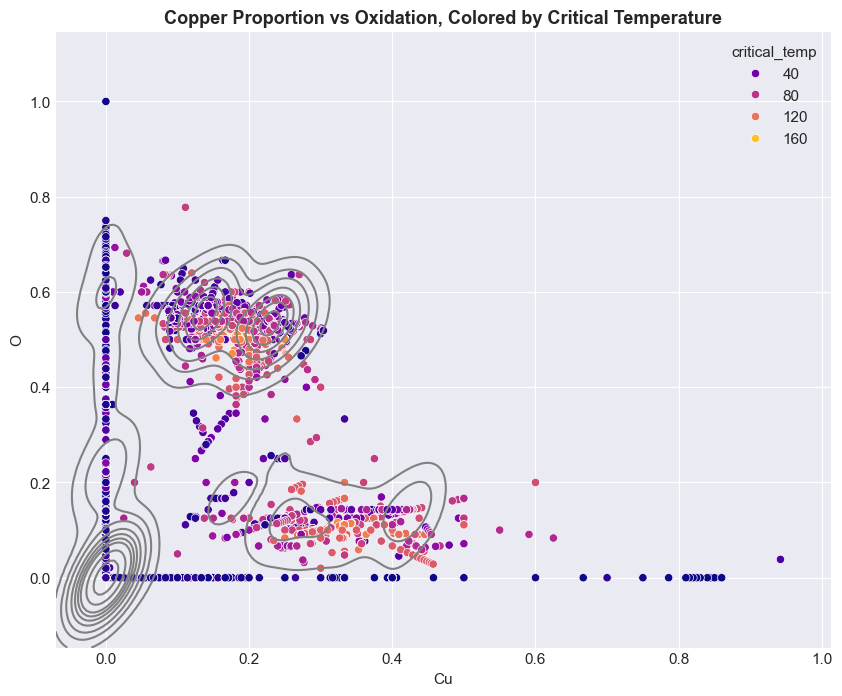

In [ ]:
# And now copper vs oxidiation
fig, ax = plt.subplots(figsize = (10, 8))
sns.scatterplot(data=norm_chemcomp, x= 'Cu', y= 'O', ax=ax, palette='plasma', hue='critical_temp')
plt.title('Copper Proportion vs Oxidation, Colored by Critical Temperature')

Text(0.5, 1.0, 'Atomic Radius Range vs Weighted Standard Deviation of Thermal Conductivity, Colored by Critical Temperature')

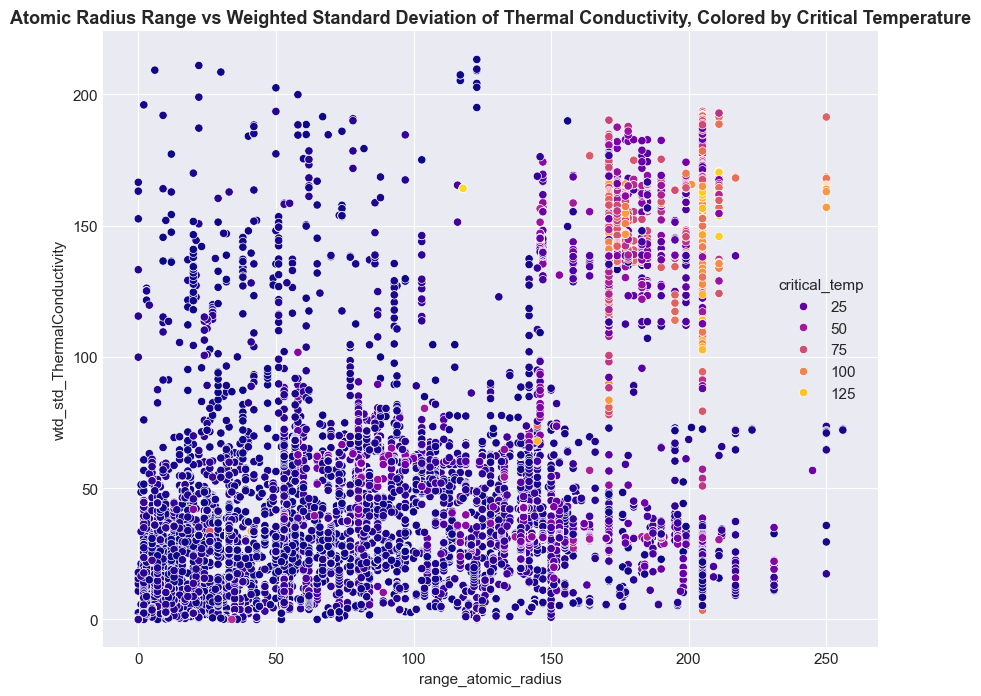

In [198]:
# Does the atomic radius range (our third highest correlation with Tc) relate to the weighted standard deviation of thermal conductivity (our highest correlation with Tc)?
fig, ax = plt.subplots(figsize= (10,8))
sns.scatterplot(data=df, x='range_atomic_radius',y='wtd_std_ThermalConductivity',palette='plasma',hue='critical_temp')
plt.title('Atomic Radius Range vs Weighted Standard Deviation of Thermal Conductivity, Colored by Critical Temperature')

Hm, so in this model maximizing both parameters corresponds to high Tc. Both parameters are large in *CBOx but does this relationship hold for similar materials that don't use CBO?

Text(0.5, 1.0, 'Weighted Mean Valence vs Weighted Standard Deviation of Thermal Conductivity, Colored by Critical Temperature')

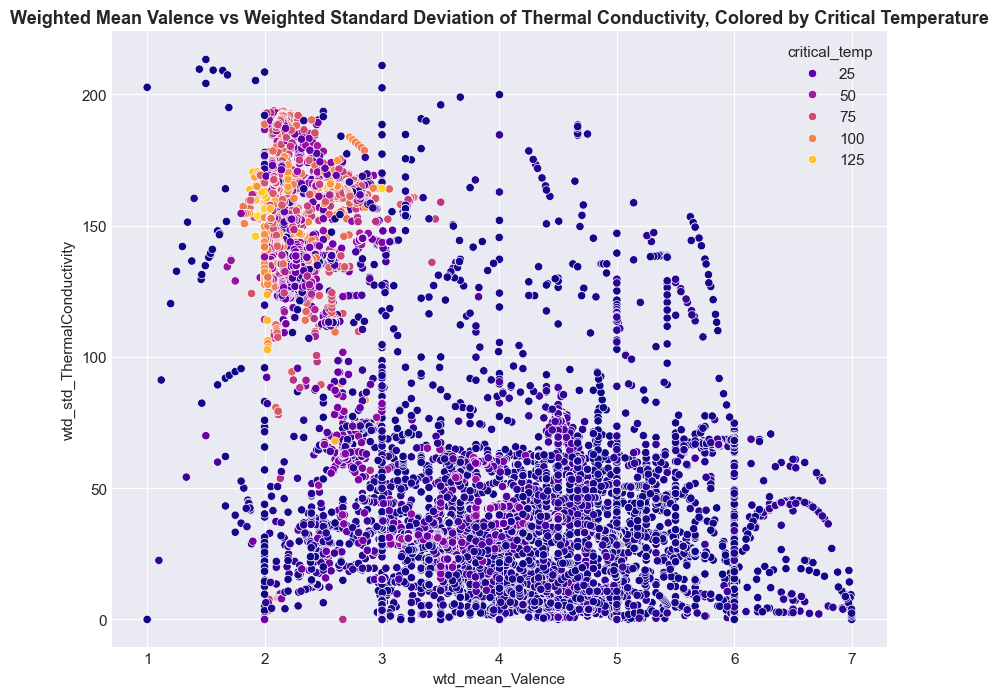

In [200]:
fig, ax = plt.subplots(figsize= (10,8))
sns.scatterplot(data=df, x='wtd_mean_Valence',y='wtd_std_ThermalConductivity',palette='plasma',hue='critical_temp')
plt.title('Weighted Mean Valence vs Weighted Standard Deviation of Thermal Conductivity, Colored by Critical Temperature')

Text(0.5, 1.0, 'Weighted Entropy of Atomic Mass vs Weighted Standard Deviation of Thermal Conductivity, Colored by Critical Temperature')

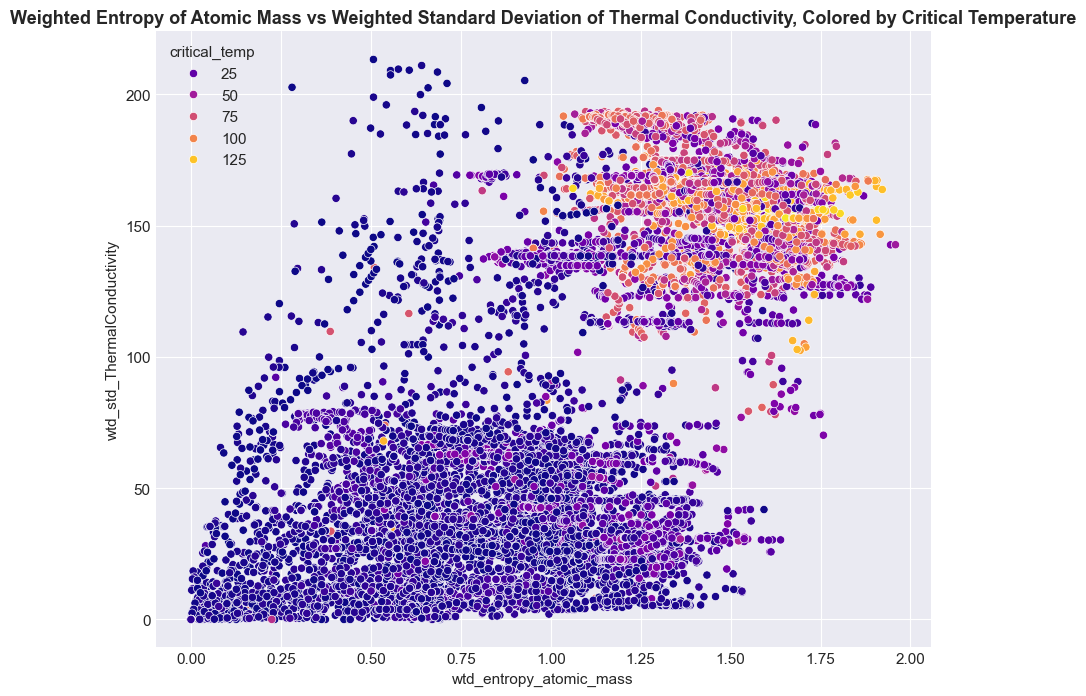

In [201]:
fig, ax = plt.subplots(figsize= (10,8))
sns.scatterplot(data=df, x='wtd_entropy_atomic_mass',y='wtd_std_ThermalConductivity',palette='plasma',hue='critical_temp')
plt.title('Weighted Entropy of Atomic Mass vs Weighted Standard Deviation of Thermal Conductivity, Colored by Critical Temperature')